Card counting may appear difficult at first, but it is actually quite simple. The concept of card counting involves assigning each card in the deck a value such as +1, -1, or 0. Then, you add them all together and this total value becomes the count. Card counters use this count to determine whether to hit or stay depending on whether the count is high or low. Many different strategies for card counting exist and these strategies implement different values for each card. For example, one strategy may count the Ace as -1 and another strategy will count it as 0. There are many more differences between the strategies than just the card values but we cannot cover them all. It is important to note that these card counting strategies at most, give a 0.5% edge to the player. For the game of Blackjack, that is all it takes.

Create Function

In [9]:
import random

def check_ace(hand): 
    """
    Checks if there's an ace in the hand in case total went over 21
    """
    if 'A' in hand:
        hand[hand.index('A')] = 'A.'
        return True
    else:
        return False
    

def hand_total(hand): 
    """
    Calculates sum total values from a list of strings using a dictionary
    """
    d_val = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
             '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11, 'A.': 1}
    return int(sum(d_val[i] for i in hand))


def deal_card(hand, deck, num_of_cards=1): 
    """
    Deals a card, defaulted to one card
    """
    for _ in range(num_of_cards):
        hand.append(deck.pop())
    return hand


def create_deck(num_of_decks=1): 
    """
    Creates a standard playing card deck, defaulted to one deck
    """
    deck = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']*4*num_of_decks
    random.shuffle(deck)
    return deck
    

def play_again():
    """
    Loops the game
    """
    while True: # Asking the player to play again or not
        ans = input("Play again? \n").lower()
        if ans == 'yes' or ans == 'y':
            return True
        elif ans == 'no' or ans == 'n':
            return False
        else:
            print("Yes or no? ")
            continue

Dealer Function

In [10]:
def dealer_turn(your_hand, dealer_hand, total, dtotal, deck, r_count, true_cnt, strategy, turn=True): 
    """
    Activates the dealer's turn if player's move was 'stay'
    """
    # Tallying wins, losses, and draws
    wins = 0
    draw = 0
    loss = 0
    
    # Looping through the moves
    while turn:
        total  = hand_total(your_hand)
        if total > 21: 
            
            # Evaluating a player's hand to see if they have an ace
            check_ace(your_hand)
            total = hand_total(your_hand)
            continue
            
        dtotal = hand_total(dealer_hand)

        # Dealing cards to the dealer if they have less than or equal to 16
        while dtotal <= 16: 
            deal_card(dealer_hand, deck)
            dtotal = hand_total(dealer_hand)
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
        # Checking if the dealer wins
        if dtotal == 21: 
            loss += 1
            break

        # Checking if the dealer busts
        elif dtotal > 21: 
            if check_ace(dealer_hand):
                continue
            else:
                wins += 1
                break
                
        # Comparing dealer hand to player hand
        elif 17 <= dtotal <= 21: 
            if dtotal > total:
                loss += 1
                break
            elif dtotal < total:
                wins += 1
                break
            elif dtotal == total:
                draw += 1
                break
            else:
                wins += 1
                break
    return [wins, loss, draw, r_count, true_cnt]

Player Turn Function

In [11]:
def player_move(your_hand, limit, true_cnt, dealer_hand):
    """
    Chooses 'hit' or 'stay' depending on the limit set and count
    """
    
    dtotal = hand_total(dealer_hand[:1])

    # Meaning there are plenty of face cards left
    if true_cnt > 0:
        if hand_total(your_hand) >= limit:
            return 'stay'
        elif hand_total(your_hand) < limit:
            return 'hit'
        elif dtotal >= 10:
            return 'stay'
        
        
    # Meaning there are plenty of low cards left: < 6 value
    elif true_cnt < 0:
        if hand_total(your_hand) <= limit:
            return 'hit'
        elif hand_total(your_hand) > limit:
            return 'stay'
        elif dtotal < 10:
            return 'hit'
        
        
    # Meaning the count is neutral so play a basic strategy    
    else:
        if hand_total(your_hand) >= 17:
            return 'stay'
        elif hand_total(your_hand) < 17:
            return 'hit'

Creating Card Counting Values

In [12]:

import pandas as pd
df = pd.read_pickle('Card_Counting_Values')

def card_counter(hand, strategy='Hi-Lo'):
    """
    Counting cards based on strategy selected
    Returns sum of the values
    """
    return sum(list(map(lambda i: df.loc[strategy][i].item(), hand)))

def true_counter(deck, r_count):
    """
    Calculates and returns the true count rounded down
    """
    try:
        return round(r_count/(len(deck)//52))
    except:
        # Compensating for when there is less than 52 cards or 1 deck left
        return r_count

Main Game

In [13]:
def blackjack(deck, limit, r_count, true_cnt, strategy):
    """
    Playing Blackjack
    """
    your_hand   = deal_card([], deck, 2)
    dealer_hand = deal_card([], deck, 2)
    
    # Tallying wins, losses, and draws
    wins = 0
    draw = 0
    loss = 0
    
    # Card Counting
    r_count  += card_counter(your_hand, strategy) + card_counter(dealer_hand[:1], strategy)
    true_cnt  = true_counter(deck, r_count)
    
    # Looping through the moves
    while len(deck) > 1:
        
        # Checking if the player has a natural blackjack
        if hand_total(your_hand) == 21 and hand_total(dealer_hand) < 21:
            
            # Card Counting
            r_count  += card_counter(dealer_hand[-1:], strategy)
            true_cnt  = true_counter(deck, r_count)
            
            wins += 1
            break
        
        # Checking if the player and the dealer tie if they both have natural blackjacks
        elif hand_total(your_hand) == 21 and hand_total(dealer_hand) == 21:
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            draw += 1
            break
        
        # Allowing the player to make a move
        move = player_move(your_hand, limit, true_cnt, dealer_hand)
        
        if move == "hit":
            
            deal_card(your_hand, deck)
            total = hand_total(your_hand)
            
            # Counter
            r_count += card_counter(your_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            # Checking if the player busts
            if  total > 21:              
                # Checking for an ace in the player hand
                if check_ace(your_hand): 
                    total = hand_total(your_hand)
                    continue
                # Otherwise they bust
                else:                    
                    loss += 1
                    break
            elif total < 21:             
                # Going back to asking the player for a move
                continue
            # Checking if the player succeeded in achieving blackjack
            elif total == 21:            
                wins += 1
                break
        elif move == "stay":
            total  = hand_total(your_hand)
            dtotal = hand_total(dealer_hand)
            
            # Counter
            r_count += card_counter(dealer_hand[-1:], strategy)
            true_cnt = true_counter(deck, r_count)
            
            # Running the function for the dealer's turn
            result = dealer_turn(your_hand, dealer_hand, total, dtotal, deck, r_count, true_cnt, strategy)
            
            # The results of the dealer's turn
            wins += result[0]
            loss += result[1]
            draw += result[2]
            
            # Counter 
            r_count  = result[3]
            true_cnt = result[4]
            break
            
    # Returning the results of the game
    return [wins, loss, draw, r_count, true_cnt]

Play Game

In [14]:
def play_blackjack(limit, strategy):
    """
    Looping the game until no cards left
    """
    deck = create_deck(6)
    
    wins = []
    draw = []
    loss = []
    rounds_played = 0
    
    r_count = 0
    true_cnt = 0
        
    while True:
        
        # Running blackjack
        game = blackjack(deck, limit, r_count, true_cnt, strategy)
        
        # Recording the results: wins, loss, draw, counts
        wins.append(game[0])
        loss.append(game[1])
        draw.append(game[2])
        rounds_played += 1
        
        r_count = game[3]
        true_cnt = game[4]
                        
        # Determining if there are enough cards left
        if len(deck) < 12:
            break
    return [wins, draw, loss, rounds_played]

Simulate Games

In [15]:
# Declaring variables for use
results      = {}
winnings     = 0
total_games  = 0
games_sim    = 1000
rec_rounds   = 10
limit        = 16
strategies   = list(df.index)
random.shuffle(strategies) # shuffling the index for more randomization


# Looping through the various strategies we have
for strat in strategies:
    print(f"Simulating {strat}")
    
    results[f"{strat}"] = []    
    c = games_sim
    
    # Simulating the games with a specific strategy
    for _ in range(games_sim):
        bj           = play_blackjack(limit, strat)

        # Recording only the last N rounds played in order to 
        # account for the effectiveness of the card counting technique
        last_wins    = sum(bj[0][-rec_rounds:])
        last_draws   = sum(bj[1][-rec_rounds:])
        winnings    += last_wins+last_draws
        total_games += rec_rounds

        wp = round((winnings/total_games)*100, 4)
        results[f"{strat}"].append(wp)

        c -= 1
        print(c, end=" ")
                
    print(f"\nCompleted {strat}\n")
    
    if strat == strategies[-1]:
        print(f"SIMULATED ALL STRATEGIES {games_sim} TIMES EACH")
        
        
games_sim = list(range(games_sim))

Simulating Hi-Opt II
999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755

999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 

999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 

999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 

999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 

Graph Results

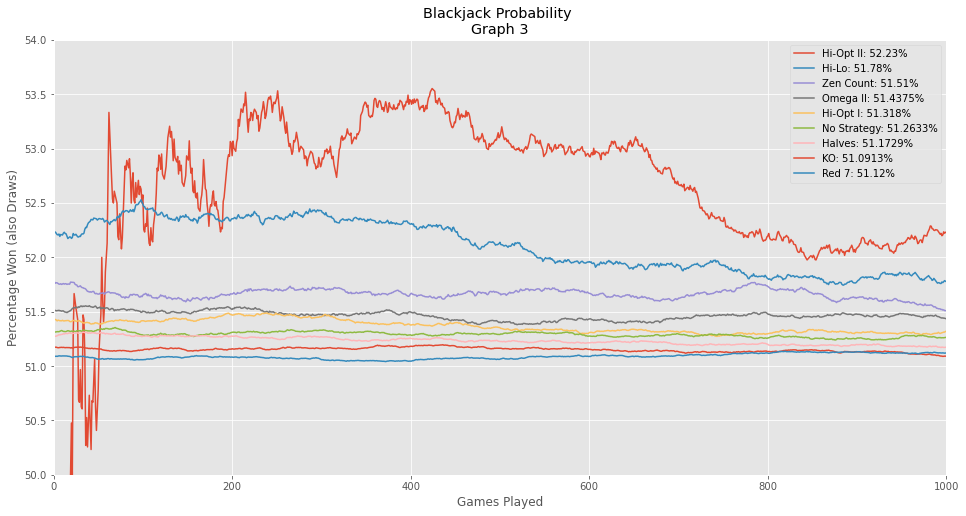

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(16,8))

# Plotting each strategies result
for i in results:
    plt.plot(games_sim, results[i], label=i+': '+str(results[i][-1])+'%')
    
plt.title("Blackjack Probability \nGraph 3")
plt.ylabel("Percentage Won (also Draws)")
plt.xlabel("Games Played")
plt.ylim([50,54])
plt.xlim([0,len(games_sim)])
plt.legend()
plt.savefig("bj_3.png")
plt.show()

In [ ]:
https://github.com/marcosan93/Blackjack-Card-Counter-Simulator